In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_xml("../data/MCC from 4-4-2023 to 7-5-2023.XML").sort_values(by="TimeStamp")
# pd.set_option()
df.head(4)

,StringValue,NumberOfParameters,Service,TechnicalEventType,TechnicalID,Description,TimeStamp,ProcessName,MemoField
198387,None,NaN,SIB,Technical Event,120000000.0,SIB\ntop temperature: 22 degrees Celsius\n[202...,2023-4-10 10:11:43.0,tLogTemp,""""""
198386,None,NaN,SIB,Technical Event,120000000.0,SIB\nbottom temperature: 16 degrees Celsius\n[...,2023-4-10 10:11:43.0,tLogTemp,""""""
198385,None,NaN,Image Detector,Technical Event,50001060.0,Detector temperature in 0.1 degrees Celsius: 244,2023-4-10 10:14:15.0,C:\Program Files\PMS\Fusion\ID_ImageDetection_...,""""""
198384,None,NaN,SIB,Technical Event,120000000.0,SIB\nFan speed of fan 1 is: 3000 rpm\n[2023^@$...,2023-4-10 10:19:13.0,tLogTemp,""""""


In [3]:
def merge_data(df, large= True):
    """
        df_run : new data that has Kv , ms
        df_c : old data that has NewCFactor and N_pulses
    """
    df_run = df[df.apply(lambda row: row.astype(str).str.contains('Last run kV').any(), axis=1)];
    if large:
        df_c = df[df.apply(lambda row: row.astype(str).str.contains(f'\[Focus=Largest\]').any(), axis=1)]
    else:
        df_c = df[df.apply(lambda row: row.astype(str).str.contains(f'\[Focus=Smallest\]').any(), axis=1)]

         


    df_run["TimeStamp"] = pd.to_datetime(df_run["TimeStamp"])
    df_c["TimeStamp"] = pd.to_datetime(df_c["TimeStamp"])

    df_run = df_run.sort_values(by="TimeStamp")
    # df_run["tt"] = df_run["TimeStamp"]
    df_c = df_c.sort_values(by="TimeStamp")

    merged_df = pd.merge_asof(df_c , df_run , on='TimeStamp' , direction='nearest')
    return merged_df

df_merged = merge_data(df)

/tmp/ipykernel_4272/2148324825.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_run["TimeStamp"] = pd.to_datetime(df_run["TimeStamp"])
/tmp/ipykernel_4272/2148324825.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c["TimeStamp"] = pd.to_datetime(df_c["TimeStamp"])


In [4]:
# merged_df['RunLength'] = merged_df["MemoField"].str.extract(r'RunLength=[^\d]*(\d+(?:\.\d+)?)');
def extract_data(df):
    df = df.copy()
    df["N_Pulses"] =  df["MemoField_x"].str.extract(r'NumberOfPulses=[^\d]*(\d+(?:\.\d+)?)');
    df["NewCFactor"] = df["MemoField_x"].str.extract(r'NewCFactor=[^\d]*(\d+(?:\.\d+)?)');
    df["kV"] = df["Description_y"].str.extract(r'kV = [^\d]*(\d+(?:\.\d+)?)');
    df["mA"] = df["Description_y"].str.extract(r'mA = [^\d]*(\d+(?:\.\d+)?)');
    df["ms"] = df["Description_y"].str.extract(r'ms = [^\d]*(\d+(?:\.\d+)?)');
    df = df[["TimeStamp" ,"NewCFactor" , "N_Pulses" , "kV"  , "mA" , "ms"]]   
    return df

df_data = extract_data(df_merged)


In [5]:
def get_cum(df):
    df["KW.S"] = (df["N_Pulses"].astype(float) * df["kV"].astype(float) * df["mA"].astype(float) * df["ms"].astype(float)) / 1e6
    #resort
    df = df.sort_values(by="TimeStamp")
    df["KW.S_Cum"] = np.cumsum(df["KW.S"])
    return df
df_data_cum  = get_cum(df_data)

In [7]:
df_data_cum.tail(1)["KW.S_Cum"].values[0]

35416.35179748894

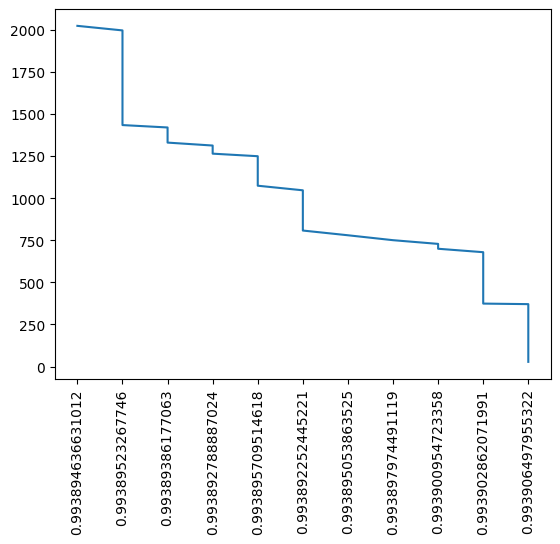

In [30]:
k=100
x= df_data_cum["NewCFactor"].values.tolist()[:k]
y = df_data_cum["KW.S_Cum"].values.tolist()[:k]

plt.plot(x, y )

# Invert the plot
plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()

plt.xticks(rotation=90);


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection  import train_test_split
from sklearn.metrics import mean_squared_error as mse

X= df_data_cum["NewCFactor"]
y = df_data_cum["KW.S_Cum"]


X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = .2 , random_state=3407)


lr = LinearRegression()

lr.fit(X_train.array.reshape(-1,1) , y_train)

mse(y_test , lr.predict(X_test.array.reshape(-1,1)) , squared = False)



1436.9835770385591

In [9]:
fail_point = 0.9453574604
lr.predict(np.array([fail_point]).reshape(1,-1)  )


array([1733949.4474222])

In [13]:
KWs_pred = lr.predict(np.array([fail_point]).reshape(1,-1)  )
remaining_KWs = KWs_pred[0] - df_data_cum.tail(1)["KW.S_Cum"].values[0]
KWs_pred ,df_data_cum.tail(1)["KW.S_Cum"].values[0] , remaining_KWs

(array([1733949.4474222]), 35416.35179748894, 1698533.09562471)

In [22]:
(df_data_cum["NewCFactor"].values.tolist()[:k])

NameError: name 'reverse' is not defined

In [11]:
df_run = df[df.apply(lambda row: row.astype(str).str.contains('Last run kV').any(), axis=1)];
df_c = df[df.apply(lambda row: row.astype(str).str.contains('\[Focus=Smallest\]').any(), axis=1)];


df_run["TimeStamp"] = pd.to_datetime(df_run["TimeStamp"])
df_c["TimeStamp"] = pd.to_datetime(df_c["TimeStamp"])

df_run = df_run.sort_values(by="TimeStamp")
df_run["tt"] = df_run["TimeStamp"]
df_c = df_c.sort_values(by="TimeStamp")

merged_df = pd.merge_asof(df_c , df_run , on='TimeStamp' , direction='nearest')
merged_df

/tmp/ipykernel_3430/3322767995.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_run["TimeStamp"] = pd.to_datetime(df_run["TimeStamp"])
/tmp/ipykernel_3430/3322767995.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c["TimeStamp"] = pd.to_datetime(df_c["TimeStamp"])


,StringValue_x,NumberOfParameters_x,Service_x,TechnicalEventType_x,TechnicalID_x,Description_x,TimeStamp,ProcessName_x,MemoField_x,StringValue_y,NumberOfParameters_y,Service_y,TechnicalEventType_y,TechnicalID_y,Description_y,ProcessName_y,MemoField_y,tt
0,None,NaN,X-Ray Generator,Technical Event,10000004.0,Run Data,2023-05-16 12:14:13,C:\Program Files\PMS\Fusion\XGS_GeneratorServi...,[FREE_TEXT] \n[FREE_TEXT] [EndReason=StandbyR...,None,NaN,Acquisition,Internal Event,510610018.0,Last run kV = 80.0\nLast run mA = 108.8\nLast ...,C:\Program Files\PMS\Fusion\Acq_acquisition_pr...,"""""",2023-05-16 12:14:13
1,None,NaN,X-Ray Generator,Technical Event,10000004.0,Run Data,2023-05-16 12:14:40,C:\Program Files\PMS\Fusion\XGS_GeneratorServi...,[FREE_TEXT] \n[FREE_TEXT] [EndReason=StandbyR...,None,NaN,Acquisition,Internal Event,510610018.0,Last run kV = 56.7\nLast run mA = 67.2\nLast r...,C:\Program Files\PMS\Fusion\Acq_acquisition_pr...,"""""",2023-05-16 12:14:40
2,None,NaN,X-Ray Generator,Technical Event,10000004.0,Run Data,2023-05-16 12:15:00,C:\Program Files\PMS\Fusion\XGS_GeneratorServi...,[FREE_TEXT] \n[FREE_TEXT] [EndReason=StandbyR...,None,NaN,Acquisition,Internal Event,510610018.0,Last run kV = 56.7\nLast run mA = 67.2\nLast r...,C:\Program Files\PMS\Fusion\Acq_acquisition_pr...,"""""",2023-05-16 12:15:00
3,None,NaN,X-Ray Generator,Technical Event,10000004.0,Run Data,2023-05-16 12:15:37,C:\Program Files\PMS\Fusion\XGS_GeneratorServi...,[FREE_TEXT] \n[FREE_TEXT] [EndReason=StandbyR...,None,NaN,Acquisition,Internal Event,510610018.0,Last run kV = 56.7\nLast run mA = 67.2\nLast r...,C:\Program Files\PMS\Fusion\Acq_acquisition_pr...,"""""",2023-05-16 12:15:37
4,None,NaN,X-Ray Generator,Technical Event,10000004.0,Run Data,2023-05-16 12:16:34,C:\Program Files\PMS\Fusion\XGS_GeneratorServi...,[FREE_TEXT] \n[FREE_TEXT] [EndReason=StandbyR...,None,NaN,Acquisition,Internal Event,510610018.0,Last run kV = 56.7\nLast run mA = 67.0\nLast r...,C:\Program Files\PMS\Fusion\Acq_acquisition_pr...,"""""",2023-05-16 12:16:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,None,NaN,X-Ray Generator,Technical Event,10000004.0,Run Data,2023-05-17 19:04:45,C:\Program Files\PMS\Fusion\XGS_GeneratorServi...,[FREE_TEXT] \n[FREE_TEXT] [EndReason=StandbyR...,None,NaN,Acquisition,Internal Event,510610018.0,Last run kV = 120.0\nLast run mA = 144.4\nLast...,C:\Program Files\PMS\Fusion\Acq_acquisition_pr...,"""""",2023-05-17 19:04:45
693,None,NaN,X-Ray Generator,Technical Event,10000004.0,Run Data,2023-05-17 19:05:01,C:\Program Files\PMS\Fusion\XGS_GeneratorServi...,[FREE_TEXT] \n[FREE_TEXT] [EndReason=StandbyR...,None,NaN,Acquisition,Internal Event,510610018.0,Last run kV = 120.0\nLast run mA = 144.7\nLast...,C:\Program Files\PMS\Fusion\Acq_acquisition_pr...,"""""",2023-05-17 19:05:01
694,None,NaN,X-Ray Generator,Technical Event,10000004.0,Run Data,2023-05-17 19:05:59,C:\Program Files\PMS\Fusion\XGS_GeneratorServi...,[FREE_TEXT] \n[FREE_TEXT] [EndReason=StandbyR...,None,NaN,Acquisition,Internal Event,510610018.0,Last run kV = 120.0\nLast run mA = 144.8\nLast...,C:\Program Files\PMS\Fusion\Acq_acquisition_pr...,"""""",2023-05-17 19:06:00
695,None,NaN,X-Ray Generator,Technical Event,10000004.0,Run Data,2023-05-17 19:06:23,C:\Program Files\PMS\Fusion\XGS_GeneratorServi...,[FREE_TEXT] \n[FREE_TEXT] [EndReason=StandbyR...,None,NaN,Acquisition,Internal Event,510610018.0,Last run kV = 120.0\nLast run mA = 144.5\nLast...,C:\Program Files\PMS\Fusion\Acq_acquisition_pr...,"""""",2023-05-17 19:06:23


In [16]:
merged_df[["TimeStamp" , "MemoField_x" , "Description_y"]].drop_duplicates().shape

(294, 3)

In [11]:
df_run.shape , df_c.shape

((991, 9), (294, 9))